<a href="https://colab.research.google.com/github/Hemistone/DeepLearning_StandAlone/blob/master/Assignment2_hemistone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)

1.0.0


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np

## Data Preparation

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=512, 
                                        shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=512,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Model Architecture

In [0]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList()
        
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        if self.act == 'relu':
            self.act = nn.ReLU()
          
    def forward(self, x):
        x = self.act(self.fc(x))
        for fc in self.linears:
            x = self.dropout(self.act(fc(x)))
        x = self.fc2(x)
        return x
      
net = MLP(3072, 10, 100, 4, 'relu', 0.1)

## Define Experiment

In [0]:
def experiment(args):
  
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout)
    net.cuda()
    print(net)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mm, weight_decay = args.weight_decay)
    
    #====== Basic information collecters ======#
    trainLossList = [] #Collecting experiments train losses
    valLossList = [] #Collecting experiments validation losses
    valAcrList = [] #Collecting experiments validation accuracies
    #==========================================#
    
    for epoch in range(args.epoch):  # loop over the dataset multiple times

        # ==== Train ===== #
        net.train()
        optimizer.zero_grad()
        
        running_loss = 0.0
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs = inputs.view(-1, 3072)
            
            inputs = inputs.cuda()
            labels = labels.cuda()
            

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            train_loss += loss.item()
            
            """
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
            """
                

        # ==== Validation ====== #
        net.eval()
        optimizer.zero_grad()
        
        correct = 0
        total = 0
        val_loss = 0 ########
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images = images.view(-1, 3072)
                
                ################################
                images = images.cuda()
                labels = labels.cuda()
                
                outputs = net(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_loss = val_loss / len(valloader)
            val_acc = 100 * correct / total
            train_loss = train_loss / len(trainloader)
            
            trainLossList.append(train_loss)
            valLossList.append(val_loss)
            valAcrList.append(val_acc)
            
        print('Debug Log : Epoch {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(epoch, train_loss, val_loss, val_acc ))


    # ===== Evaluation(Test) ===== #
    net.eval()
    optimizer.zero_grad()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
            
    return visualize(args, trainLossList, valLossList, valAcrList, test_acc)
    

##Visualization

In [0]:
import matplotlib.pyplot as plt

def visualize(args, trainLossList, valLossList, valAcrList, test_acc):
    epoch = []
    for i in range(len(trainLossList)):
        epoch.append(i)
    fig = plt.figure(figsize = (10, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(epoch, trainLossList, label="train")
    ax1.plot(epoch, valLossList, label="validation")
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(epoch, valAcrList)
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    
    fig.suptitle('< n_layer : {} , hid_dim : {} , dropoutRate : {}, L2 alpha : {} >   test_acc : {}%'.format(args.n_layer, args.hid_dim, args.dropout, args.weight_decay, test_acc))
    
    plt.show()


## Experiment

MLP(
  (dropout): Dropout(p=0.1)
  (fc): Linear(in_features=3072, out_features=500, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=500, out_features=500, bias=True)
  )
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (act): ReLU()
)
Debug Log : Epoch 0, Train Loss: 2.0938866914749146, Val Loss: 1.9121832665364453, Val Acc: 33.8
Debug Log : Epoch 1, Train Loss: 1.8330762098312379, Val Loss: 1.7600208885350805, Val Acc: 38.29
Debug Log : Epoch 2, Train Loss: 1.7197249187469483, Val Loss: 1.684946121683546, Val Acc: 40.75
Debug Log : Epoch 3, Train Loss: 1.653462268447876, Val Loss: 1.6335519316849436, Val Acc: 42.14
Debug Log : Epoch 4, Train Loss: 1.6075385149002075, Val Loss: 1.596982296105403, Val Acc: 43.6
Debug Log : Epoch 5, Train Loss: 1.5672183280944825, Val Loss: 1.5696832495889845, Val Acc: 44.07
Debug Log : Epoch 6, Train Loss: 1.5352613500595094, Val Loss: 1.545069923826084, Val Acc: 45.45
Debug Log : Epoch 7, Train Loss: 1.5045815408706664, Va

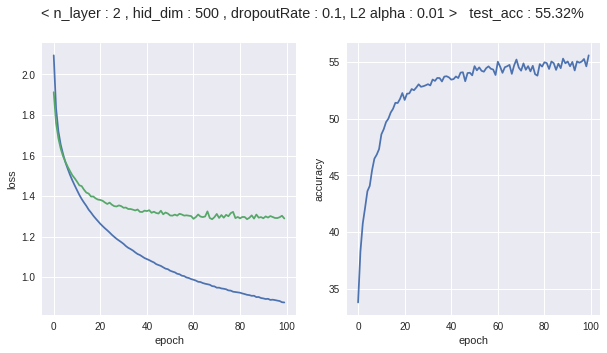

MLP(
  (dropout): Dropout(p=0.2)
  (fc): Linear(in_features=3072, out_features=500, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=500, out_features=500, bias=True)
  )
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (act): ReLU()
)
Debug Log : Epoch 0, Train Loss: 2.1035491230010988, Val Loss: 1.9212731191307117, Val Acc: 31.85
Debug Log : Epoch 1, Train Loss: 1.8448653942108155, Val Loss: 1.769058899514994, Val Acc: 37.37
Debug Log : Epoch 2, Train Loss: 1.7325500747680664, Val Loss: 1.6889796158310715, Val Acc: 40.09
Debug Log : Epoch 3, Train Loss: 1.6650462310791017, Val Loss: 1.6414592736845564, Val Acc: 42.0
Debug Log : Epoch 4, Train Loss: 1.6181179527282714, Val Loss: 1.602267416419497, Val Acc: 43.24
Debug Log : Epoch 5, Train Loss: 1.5800428964614868, Val Loss: 1.5762396018216565, Val Acc: 44.25
Debug Log : Epoch 6, Train Loss: 1.5455067596435548, Val Loss: 1.5533990708126384, Val Acc: 44.92
Debug Log : Epoch 7, Train Loss: 1.5163030836105347,

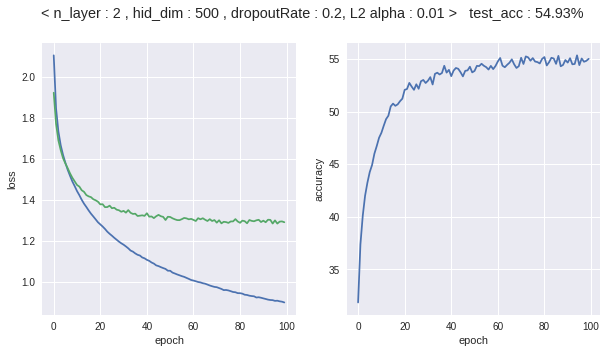

In [56]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")


args.n_layer = 5
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

args.lr = 0.001
args.mm = 0.9
args.epoch = 100

#==additional entities===#
args.dropout = 0
args.weight_decay = 0.01
#========================#

#==== variables ===#
list_var1 = [2] #layer number
list_var2 = [500] #hidden dimension
list_var3 = [0.1, 0.2] #dropout rate
list_var4 = [0.01] #L2 reg factors(alpha)
#==================#


for var4 in list_var4:
    for var3 in list_var3:
        for var1 in list_var1:
            for var2 in list_var2:
                args.n_layer = var1
                args.hid_dim = var2
                args.dropout = var3
                args.weight_decay = var4
                experiment(args)